# Analyising 400m and 1500m impact on the 800m

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector as mariadb

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

In [148]:
mariadb_connection = mariadb.connect(user='root', password='', database='power_of_ten')

In [149]:
data = pd.read_sql_query("SELECT ei.name AS name, ei.athlete_id AS id, ei.ranking_gender AS gender, ei.ranking_year AS year, ei.perf AS perf_800, fi.perf AS perf_1500, fo.perf AS perf_400 FROM ranking AS ei JOIN ranking AS fi ON ei.athlete_id=fi.athlete_id AND ei.ranking_year = fi.ranking_year JOIN ranking AS fo ON ei.athlete_id=fo.athlete_id AND ei.ranking_year=fo.ranking_year  WHERE ei.ranking_event = 800 AND fi.ranking_event = 1500 AND fo.ranking_event = 400;", mariadb_connection)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 7 columns):
name         1029 non-null object
id           1029 non-null int64
gender       1029 non-null object
year         1029 non-null int64
perf_800     1029 non-null int64
perf_1500    1029 non-null int64
perf_400     1029 non-null int64
dtypes: int64(5), object(2)
memory usage: 56.3+ KB


### Checking out the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d3b4790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11bcf4510>]], dtype=object)

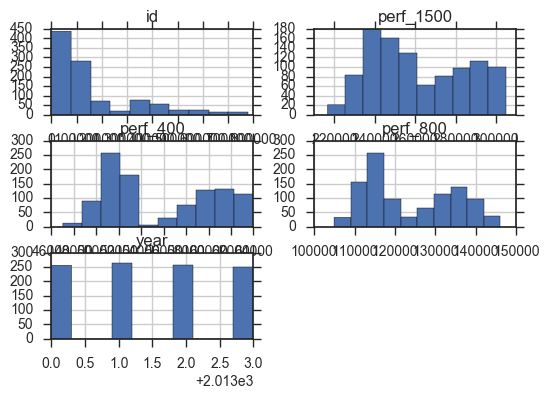

In [150]:
data.hist()

In [402]:
#Split the data into training and test data
is_m = data['gender'] == "M"
is_f = data['gender'] == "W"
year_train = data['year'] != 2016
year_test = data['year'] == 2016
train_data = data[data['year'] != 2016]
train_data_m = data[is_m & year_train]
train_data_f = data[is_f & year_train]
test_data_m = data[is_m & year_test]
test_data_f = data[is_f & year_test]
train_data_f.info()
data_m = data[is_m].sort_values(["perf_800"], ascending=False)
data_f = data[is_f].sort_values(["perf_800"], ascending=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 400 to 1028
Data columns (total 7 columns):
name         366 non-null object
id           366 non-null int64
gender       366 non-null object
year         366 non-null int64
perf_800     366 non-null int64
perf_1500    366 non-null int64
perf_400     366 non-null int64
dtypes: int64(5), object(2)
memory usage: 22.9+ KB


### Comparing 400m to 800m

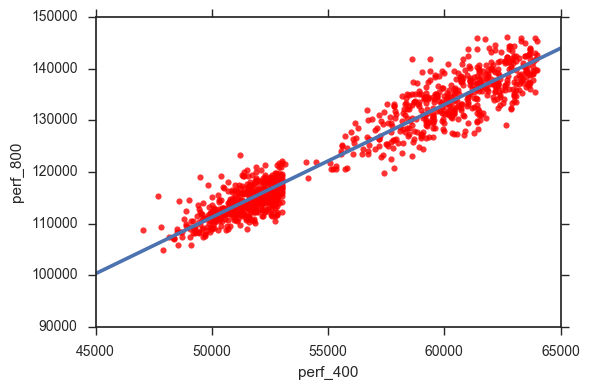

In [169]:
sns.regplot(data["perf_400"], data["perf_800"], order=1, ci=None, scatter_kws={'color':'r'})

In [201]:
from IPython.display import Image
import matplotlib.ticker as tkr
from math import sqrt

In [171]:
def tick_func(x, pos):
    milliseconds = x % 1000
    s = x / 1000
    seconds = s % 60
    s /= 60
    minutes = s % 60
    if minutes < 1:
        return "{:02}.{}".format(int(seconds), int(milliseconds))
    else:
        return "{}:{:02}.{}".format(int(minutes), int(seconds), int(milliseconds))

milli_format = tkr.FuncFormatter(tick_func)

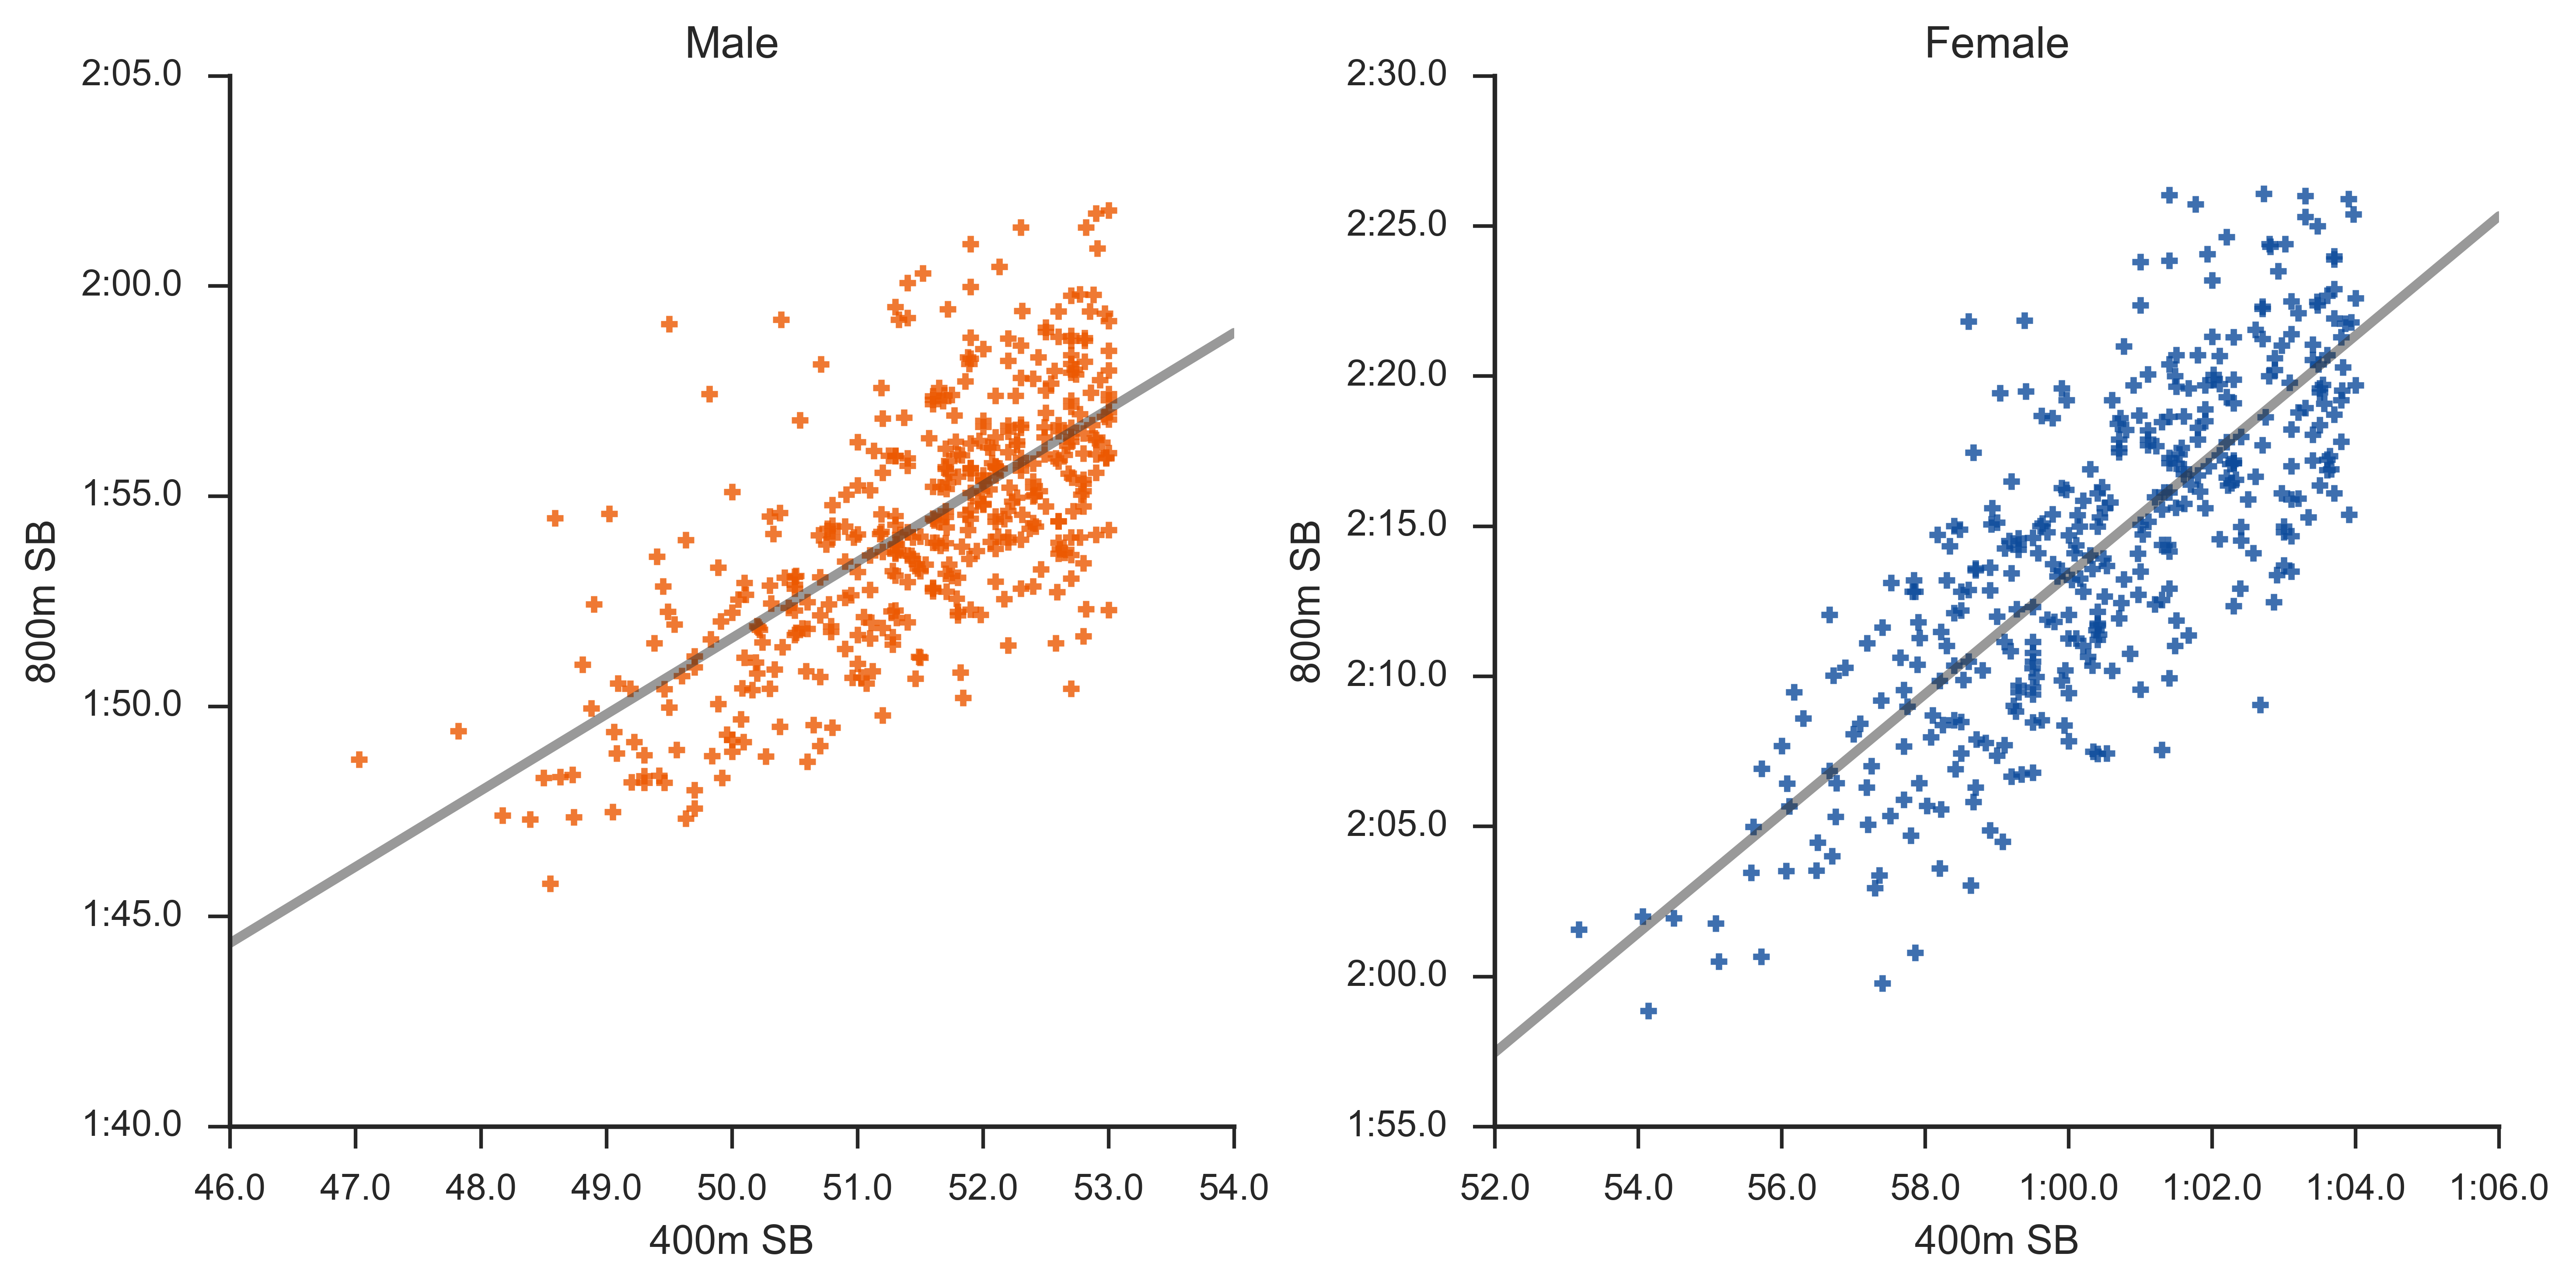

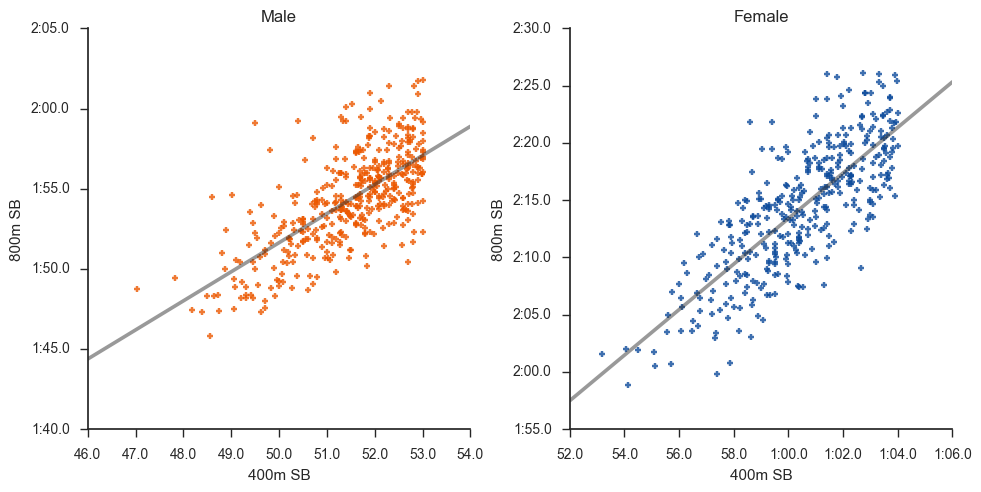

In [172]:
sns.set_style("ticks")
#print(data)
#for each in data:
#    print(each)
#    if each['gender'] == 'M':
 #       data['color'] += ['#FF0000']
eight_four = sns.lmplot(x="perf_400", y="perf_800", data=train_data, col="gender", hue="gender", ci=None, markers="+", line_kws={'color':'#343434', "alpha":0.5},palette=dict(M="#ec5800",W="#0D4B9B"), scatter_kws={"alpha":0.8}, sharex=False, sharey=False)
sns.despine()
eight_four.set(xlabel='400m SB', ylabel="800m SB")
for axlist in eight_four.axes:
    for ax in axlist:
        ax.yaxis.set_major_formatter(milli_format)
        ax.xaxis.set_major_formatter(milli_format)
for ax, title in zip(eight_four.axes.flat, ["Male", "Female"]):
    ax.set_title(title)
eight_four.savefig("eight_four.png", dpi=600)
Image(filename='eight_four.png')

In [186]:
# Regression Coefficients (Ordinary Least Squares)
# MALE
regr_four_m = skl_lm.LinearRegression()

X = train_data_m["perf_400"].reshape(-1, 1)
y = train_data_m["perf_800"]

regr_four_m.fit(X,y)
print(regr_four_m.intercept_)
print(regr_four_m.coef_)

20875.2147903
[ 1.81506376]


In [178]:
# Regression Coefficients (Ordinary Least Squares)
# FEMALE
regr_four_f = skl_lm.LinearRegression()

X = train_data_f["perf_400"].reshape(-1, 1)
y = train_data_f["perf_800"]

regr_four_f.fit(X,y)
print(regr_four_f.intercept_)
print(regr_four_f.coef_)

14015.2397145
[ 1.98967297]


In [254]:
# Calculate popular
def popular_formula(x, y):
    return np.subtract(((x.ravel()+5000)*2), y) ** 2

In [301]:
#Mean Squared Error MALE
X = test_data_m["perf_400"].reshape(-1,1)
y = test_data_m["perf_800"]

print(sqrt(np.mean((regr_four_m.predict(X) - y) ** 2)))
print(regr_four_m.score(X, y))
print(sqrt(np.mean(popular_formula(X, y))))
r2_score(regr_four_m.predict(X), y)

2557.69185658
0.406963199341
2877.40403285


-0.38928869886388839

In [302]:
# Mean Squared Error FEMALE
X = test_data_f["perf_400"].reshape(-1,1)
y = test_data_f["perf_800"]

print(sqrt(np.mean((regr_four_f.predict(X) - y) ** 2)))
print(regr_four_f.score(X, y))
print(sqrt(np.mean(popular_formula(X, y))))
r2_score(regr_four_f.predict(X), y)

3452.56294146
0.618517809908
4532.35002777


0.37138060335781398

In [15]:
four_pred = regr_four_m.predict(50500)
print four_pred

[ 112315.85386774]


In [180]:
#MALE
four_lm_m = smf.ols(formula='perf_800 ~ perf_400', data=train_data_m).fit()
four_lm_m.params

Intercept    20875.214790
perf_400         1.815064
dtype: float64

In [181]:
#FEMALE
four_lm_f = smf.ols(formula='perf_800 ~ perf_400', data=train_data_f).fit()
four_lm_f.params

Intercept    14015.239715
perf_400         1.989673
dtype: float64

In [183]:
# Calculate Confidence
four_lm_f.conf_int()

                     0             1
Intercept  4187.550283  23842.929146
perf_400      1.827224      2.152122

In [18]:
four_lm.pvalues
# Based on this we can reject the null hypothesis
# that there is no relationship between the 400m and 800m.

Intercept    0.043004
perf_400     0.000000
dtype: float64

In [185]:
# print the R-Squared value for the model
four_lm_m.rsquared

0.47488530270246321

### Comparing the 1500m to the 800m

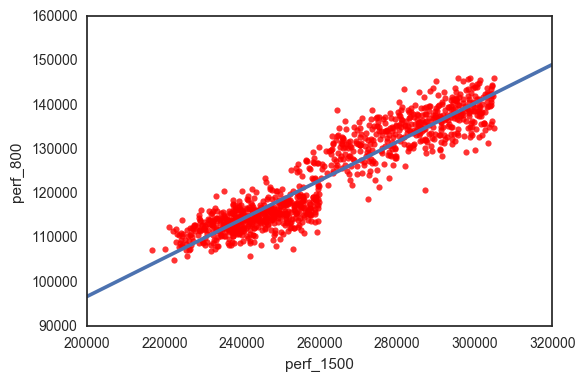

In [20]:
sns.regplot(data["perf_1500"], data["perf_800"], order=1, ci=None, scatter_kws={'color':'r'})

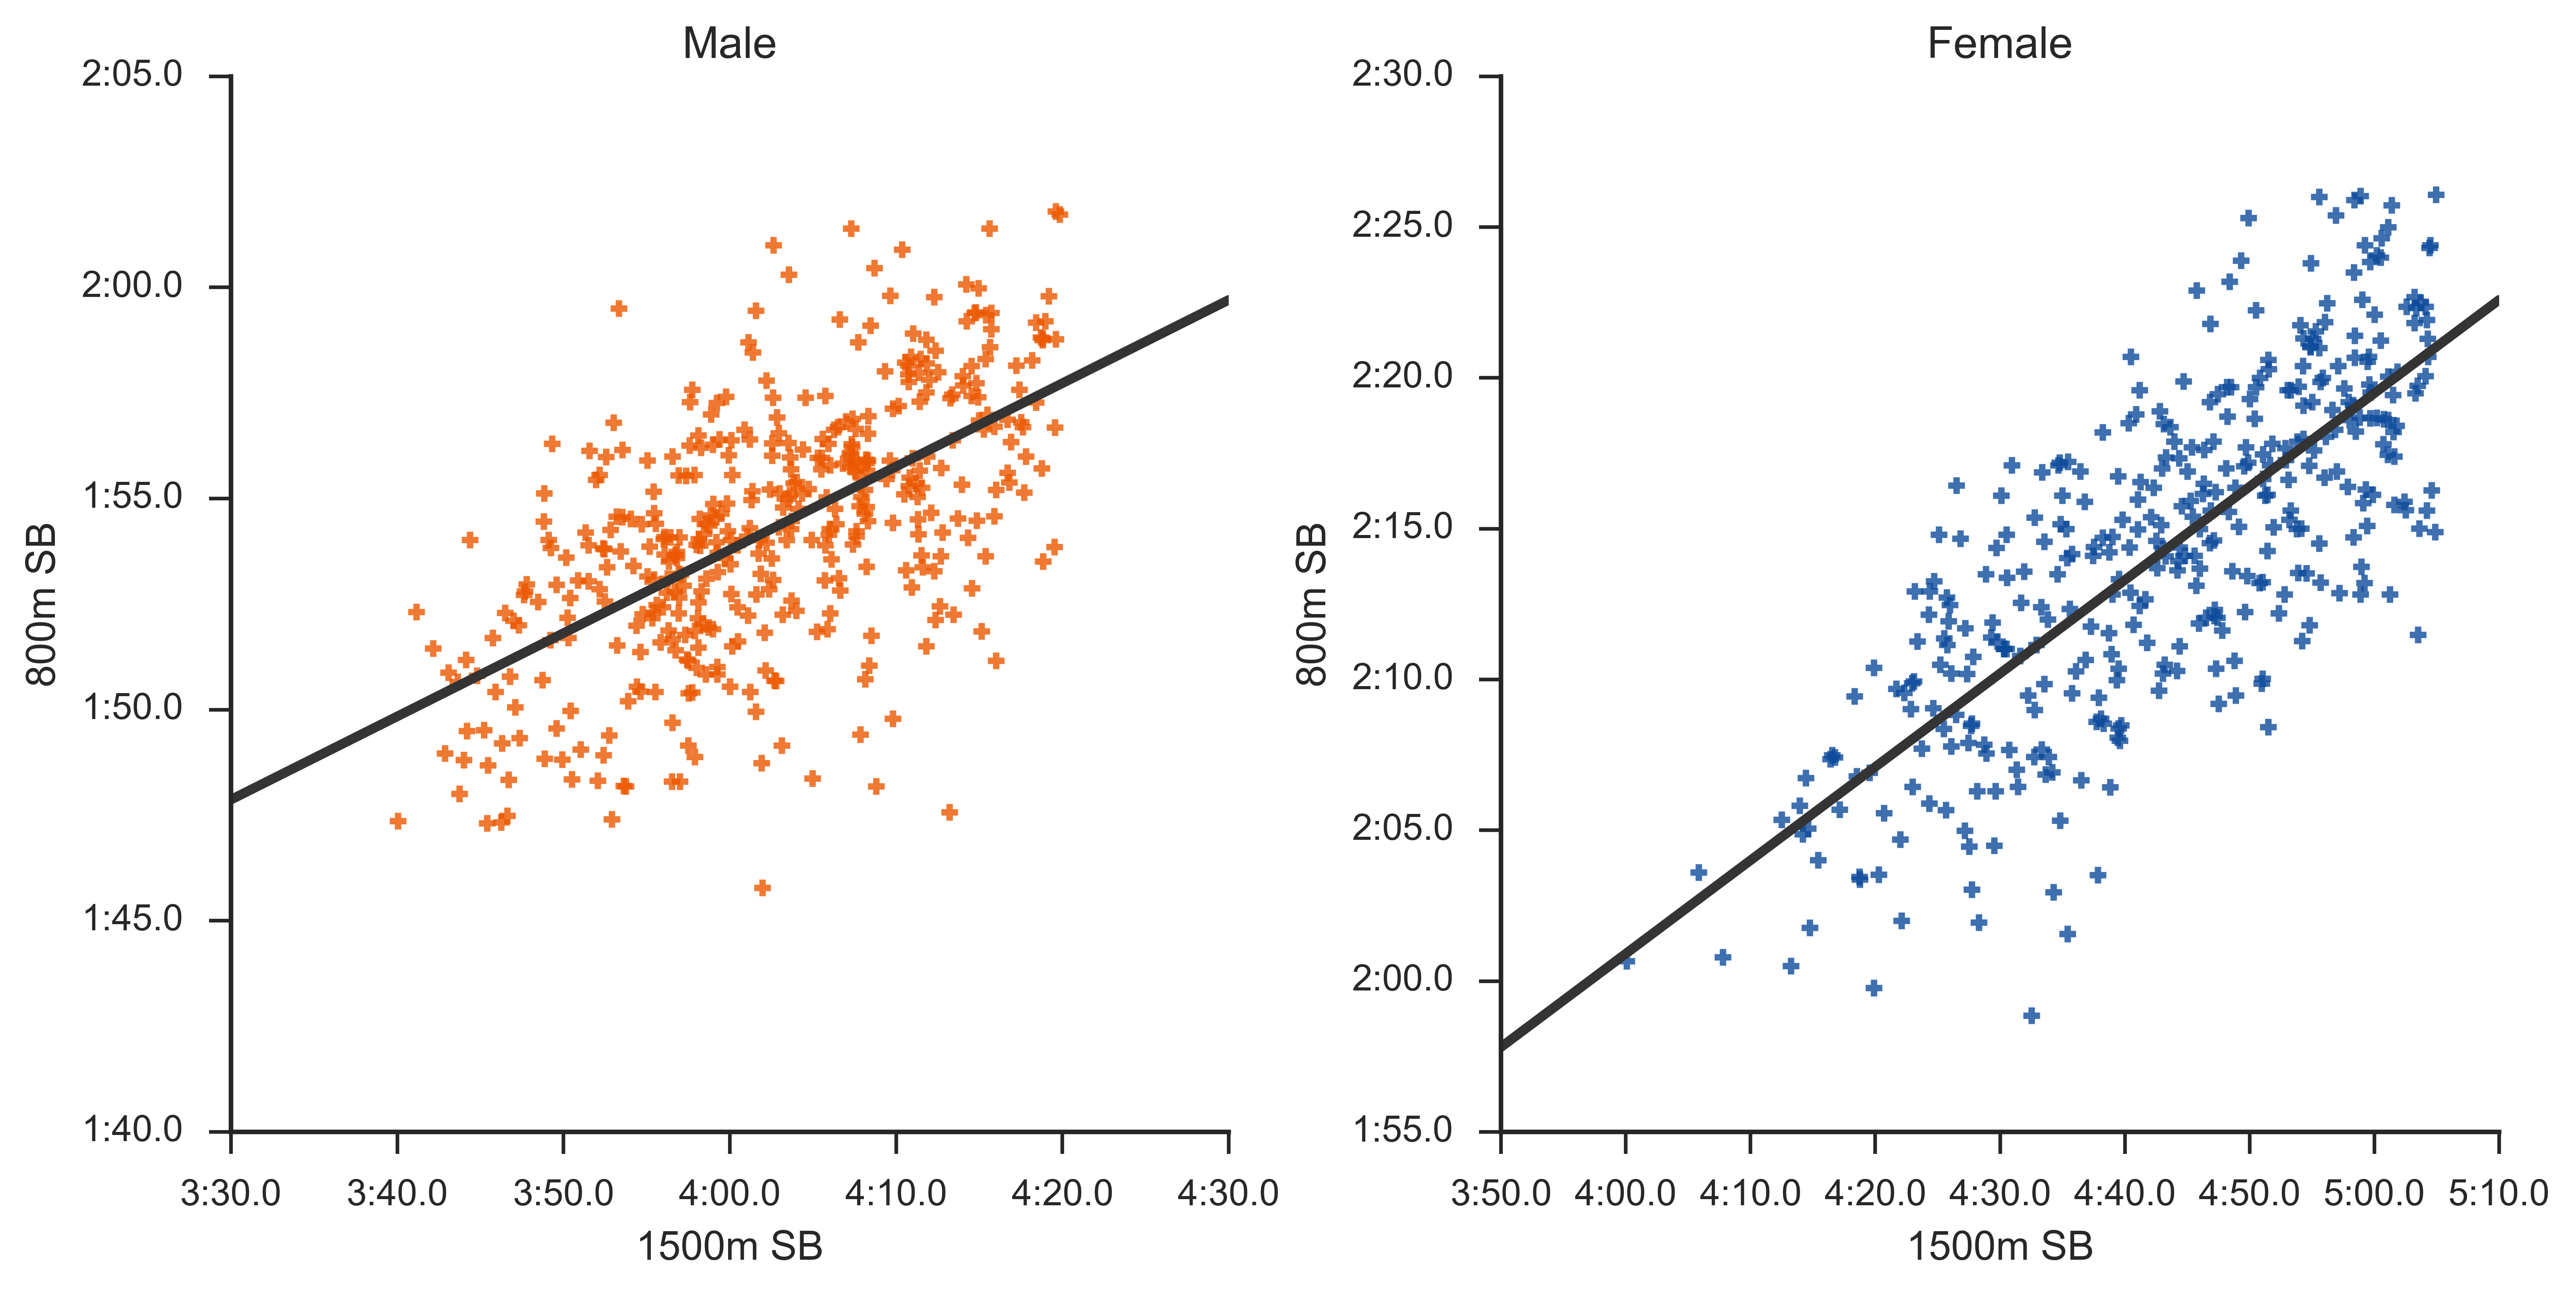

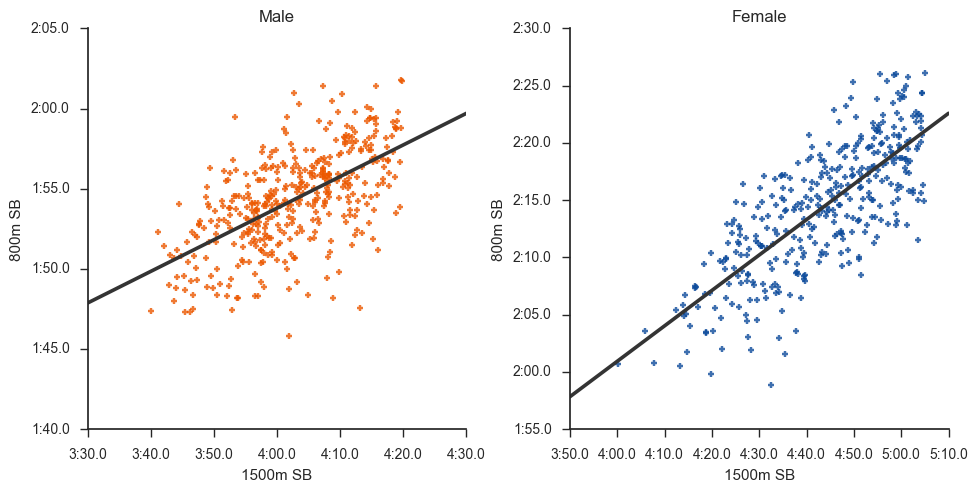

In [258]:
eight_fift = sns.lmplot(x="perf_1500", y="perf_800", data=train_data, col="gender", hue="gender", ci=None, markers="+", line_kws={'color':'#343434'},palette=dict(M="#ec5800",W="#0D4B9B"), sharex=False, sharey=False)
sns.despine()
eight_fift.set(xlabel='1500m SB', ylabel="800m SB")
for axlist in eight_fift.axes:
    for ax in axlist:
        ax.yaxis.set_major_formatter(milli_format)
        ax.xaxis.set_major_formatter(milli_format)
for ax, title in zip(eight_fift.axes.flat, ["Male", "Female"]):
    ax.set_title(title)
eight_fift.savefig("eight_fift.png", dpi=600)
Image(filename='eight_fift.png')

IndexError: tuple index out of range

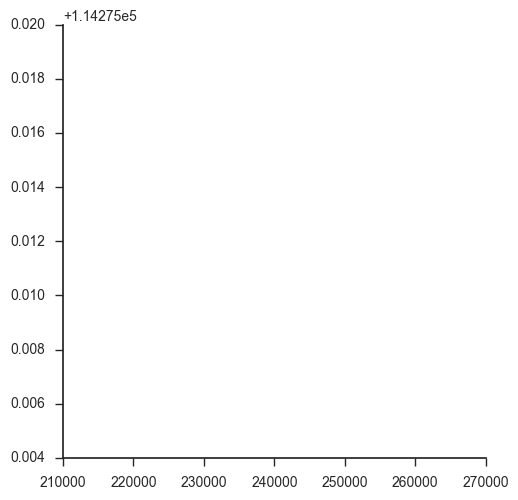

In [320]:
eight_fift = sns.lmplot(x="perf_1500", y="perf_800", data=train_data_m, ci=None, markers="+", line_kws={}, scatter_kws={'color':train_data_m['perf_800']})
eight_fift.set(xlabel='1500m SB', ylabel="800m SB")
for axlist in eight_fift.axes:
    for ax in axlist:
        ax.yaxis.set_major_formatter(milli_format)
        ax.xaxis.set_major_formatter(milli_format)

In [21]:
fift_lm = smf.ols(formula='perf_800 ~ perf_1500', data=data).fit()
fift_lm.params

Intercept    9536.457619
perf_1500       0.436152
dtype: float64

In [260]:
# Regression Coefficients (Ordinary Least Squares)
# MALE
regr_fift_m = skl_lm.LinearRegression()

X = train_data_m["perf_1500"].reshape(-1, 1)
y = train_data_m["perf_800"]

regr_fift_m.fit(X,y)
print(regr_fift_m.intercept_)
print(regr_fift_m.coef_)

66439.4273062
[ 0.19727915]


In [264]:
# Regression Coefficients (Ordinary Least Squares)
# FEMALE
regr_fift_f = skl_lm.LinearRegression()

X = train_data_f["perf_1500"].reshape(-1, 1)
y = train_data_f["perf_800"]

regr_fift_f.fit(X,y)
print(regr_fift_f.intercept_)
print(regr_fift_f.coef_)
print(regr_fift_f.predict(240070))

46602.8176314
[ 0.30962192]
[ 120933.75291647]


In [299]:
#Mean Squared Error MALE
X = test_data_m["perf_1500"].reshape(-1,1)
y = test_data_m["perf_800"]

print(sqrt(np.mean((regr_fift_m.predict(X) - y) ** 2)))
print(regr_fift_m.score(X, y))
print(sqrt(np.mean(popular_formula(X, y))))
#print regr_fift_m.predict(X)
#print y
r2_score(regr_fift_m.predict(X), y)

2436.43098242
0.46186228581
382770.194395


-0.45253221387656928

In [300]:
#Mean Squared Error FEMALE
X = test_data_f["perf_1500"].reshape(-1,1)
y = test_data_f["perf_800"]

print(sqrt(np.mean((regr_fift_f.predict(X) - y) ** 2)))
print(regr_fift_f.score(X, y))
print(sqrt(np.mean(popular_formula(X, y))))
r2_score(regr_fift_f.predict(X), y)

3695.46370438
0.562952198225
441806.74513


0.34049156451411

In [22]:
# Calculate Confidence
fift_lm.conf_int()

                     0             1
Intercept  6881.039749  12191.875489
perf_1500     0.426053      0.446250

In [23]:
fift_lm.pvalues
# Based on this we can reject the null hypothesis
# that there is no relationship between the 1500m and 800m.

Intercept    3.344217e-12
perf_1500    0.000000e+00
dtype: float64

In [289]:
# print the R-Squared value for the model
fift_lm_m.rsquared

NameError: name 'fift_fift_m' is not defined

### Comparing the 400m to 1500m

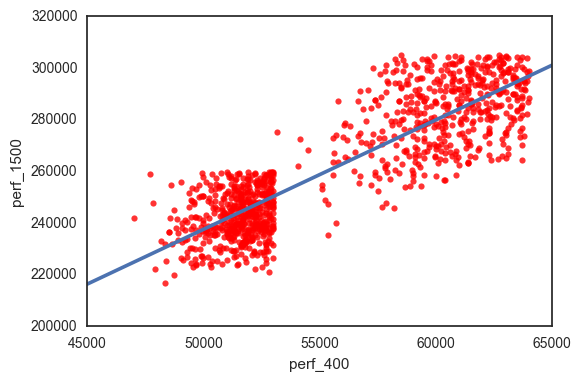

In [25]:
sns.regplot(data["perf_400"], data["perf_1500"], ci=None, order=1, scatter_kws={'color':'r'})

### Mixing it all together

In [304]:
#MALE
all_lm_m = smf.ols(formula='perf_800 ~ perf_400 + perf_1500', data=train_data_m).fit()
all_lm_m.params
d = {"perf_400":47900, "perf_1500":222300} #, "perf_1500":252700}
all_lm_m.predict(d)

array([ 105766.89519405])

In [283]:
#FEMALE
all_lm_f = smf.ols(formula='perf_800 ~ perf_400 + perf_1500', data=train_data_f).fit()
all_lm_f.params

Intercept   -11761.804076
perf_400         1.419496
perf_1500        0.212700
dtype: float64

In [295]:
X = test_data_m["perf_400"].reshape(-1,1)
X1 = test_data_m["perf_1500"].reshape(-1,1)
y = test_data_m["perf_800"]

d = {"perf_400":X, "perf_1500":X1}
#MALE ERROR
print(sqrt(np.mean((all_lm_m.predict(d) - y) ** 2)))
print(all_lm_m.rsquared)
r2_score(all_lm_m.predict(d), y)

1885.9188923
0.677130985055


0.51616169901950304

In [294]:
X = test_data_f["perf_400"].reshape(-1,1)
X1 = test_data_f["perf_1500"].reshape(-1,1)
y = test_data_f["perf_800"]

d = {"perf_400":X, "perf_1500":X1}
#MALE ERROR
print(sqrt(np.mean((all_lm_f.predict(d) - y) ** 2)))
r2_score(all_lm_f.predict(d), y)

2326.00153762


0.8058603560134675

In [291]:
from sklearn.metrics import r2_score

In [293]:
r2_score(all_lm_f.predict(d), y)

0.8058603560134675

In [27]:
all_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               perf_800   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 1.421e+04
Date:                Sat, 28 Jan 2017   Prob (F-statistic):               0.00
Time:                        14:35:56   Log-Likelihood:                -9300.8
No. Observations:                1029   AIC:                         1.861e+04
Df Residuals:                    1026   BIC:                         1.862e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -2601.5048    752.276     -3.458      0.001     -4077.680 -1125.330
perf_400       1.3926      0.027     51.556      0.000         1.340     1.446
perf_1500      0.1861      0.006     33.465      0.000         0.175     0.197
==============================================================================
Omnibus:                       26.428   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.151
Skew:                           0.173   Prob(JB):                     5.77e-11
Kurtosis:                       3.990   Cond. No.                     3.18e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
all_lm.predict(pd.DataFrame({'perf_400':[49900], 'perf_1500':[250000]}))

array([ 113405.34243448])

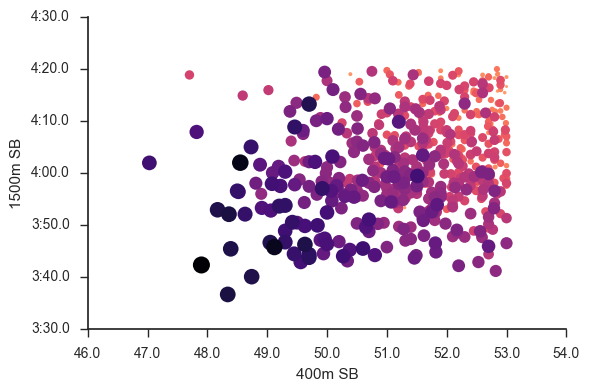

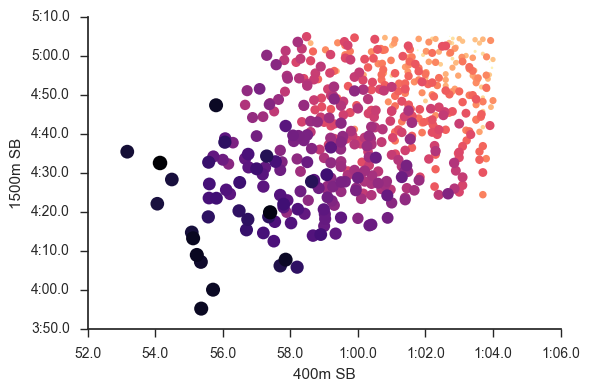

In [440]:
#Cool Graph
def time_to_color(time):
    return((time/500)*2-400)

def time_to_size(time):
    return(200-(time/100-1000))

def time_to_color_f(time):
    return((time/500)*2-300)

def time_to_size_f(time):
    return(110-(time/250-475))
    
x = data_m["perf_400"]
y = data_m["perf_1500"]
x_f = data_f["perf_400"]
y_f = data_f["perf_1500"]
colors = data_m["perf_800"]
colors_f = data_f["perf_800"]
#print time_to_size(colors)
plt.figure()
fig1 = plt.scatter(x, y, c=time_to_color(colors), cmap='magma', s=time_to_size(colors), edgecolors='none')
plt.xlabel("400m SB")
plt.ylabel("1500m SB")
plt.gca().yaxis.set_major_formatter(milli_format)
plt.gca().xaxis.set_major_formatter(milli_format)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tight_layout()
plt.gcf().savefig("four_fift_m.png", dpi=600)
plt.show()
fig = plt.scatter(x_f, y_f, c=time_to_color_f(colors_f), cmap='magma', s=time_to_size_f(colors_f), edgecolors='none')

plt.xlabel("400m SB")
plt.ylabel("1500m SB")
plt.gca().yaxis.set_major_formatter(milli_format)
plt.gca().xaxis.set_major_formatter(milli_format)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tight_layout()
plt.gcf().savefig("four_fift_f.png", dpi=600)
plt.show()


In [311]:
import matplotlib.cm as cm